In [1]:
! pip install -U langchain_groq langchain tavily-python replicate langgraph matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.0/974.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.7/314.7 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [10]:
pip install -qU langchain-community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 5.7 MB/s eta 0:00:00


In [4]:
import os
from google.colab import userdata
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

In [5]:
os.environ["REPLICATE_API_TOKEN"] = userdata.get('REPLICATE_API_TOKEN')

In [6]:
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')

In [7]:
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = userdata.get('LANGCHAIN_API_KEY')

In [8]:
os.environ["LANGCHAIN_PROJECT"] = "llama3-tool-use-agent"

In [11]:
import replicate

from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_community.tools.tavily_search import TavilySearchResults

@tool
def magic_function(input: int) -> int:
    """Applies a magic function to an input."""
    return input + 2

@tool
def web_search(input: str) -> str:
    """Runs web search."""
    web_search_tool = TavilySearchResults()
    docs = web_search_tool.invoke({"query": input})
    return docs

@tool
def text2image(text: str) -> str:
    """generate an image based on a text."""
    output = replicate.run(
        "stability-ai/sdxl:7762fd07cf82c948538e41f63f77d685e02b063e37e496e96eefd46c929f9bdc",
        input={
            "width": 1024,
            "height": 1024,
            "prompt": text, # a yellow lab puppy running free with wild flowers in the mountain behind
            "scheduler": "KarrasDPM",
            "num_outputs": 1,
            "guidance_scale": 7.5,
            "apply_watermark": True,
            "negative_prompt": "worst quality, low quality",
            "prompt_strength": 0.8,
            "num_inference_steps": 60
        }
    )
    print(output)
    return output[0]

@tool
def image2text(image_url: str, prompt: str) -> str:
    """generate text for image_url based on prompt."""
    input = {
        "image": image_url,
        "prompt": prompt
    }

    output = replicate.run(
        "yorickvp/llava-13b:b5f6212d032508382d61ff00469ddda3e32fd8a0e75dc39d8a4191bb742157fb",
        input=input
    )

    return "".join(output)

@tool
def text2speech(text: str) -> int:
    """convert text to a speech."""
    output = replicate.run(
        "cjwbw/seamless_communication:668a4fec05a887143e5fe8d45df25ec4c794dd43169b9a11562309b2d45873b0",
        input={
            "task_name": "T2ST (Text to Speech translation)",
            "input_text": text,
            "input_text_language": "English",
            "max_input_audio_length": 60,
            "target_language_text_only": "English",
            "target_language_with_speech": "English"
        }
    )
    return output['audio_output']

def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print(f"Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

# List of tools
tools = [
    magic_function,
    web_search,
    text2image,
    image2text,
    text2speech
]

In [12]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [13]:
from datetime import datetime
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig

# Assistant
class Assistant:

    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            # Get any user-provided configs
            image_url = config['configurable'].get("image_url", None)
            # Append to state
            state = {**state, "image_url": image_url}
            # Invoke the tool-calling LLM
            result = self.runnable.invoke(state)
            # If it is a tool call -> response is valid
            # If it has meaninful text -> response is valid
            # Otherwise, we re-prompt it b/c response is not meaninful
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

# Prompt
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant for with five tools: (1) web search, "
            "(2) a custom, magic_function, (3) text to image, (4) image to text "
            "(5) text to speech. Use these provided tools in response to the user question. "
            "Your image url is: {image_url} "
            "Current time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

# LLM chain
llm = ChatGroq(temperature=0, model="llama3-70b-8192")
assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)

In [14]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.runnables import RunnableLambda

# Graph
builder = StateGraph(State)

# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))

# Define edges: these determine how the control flow moves
builder.set_entry_point("assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
    # "tools" calls one of our tools. END causes the graph to terminate (and respond to the user)
    {"tools": "tools", END: END},
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
memory = SqliteSaver.from_conn_string(":memory:")
graph = builder.compile(checkpointer=memory)

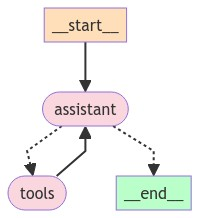

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [16]:
questions = ["What is magic_function(3)",
             "What is the weather in SF?",
             "Generate an image based upon this text: 'a yellow lab puppy running free with wild flowers in the mountain behind'",
             "Tell me a story about this image",
             "Convert this text to speech: The image features a small white dog running down a dirt path, surrounded by a beautiful landscape. The dog is happily smiling as it runs, and the path is lined with colorful flowers, creating a vibrant and lively atmosphere. The scene appears to be set in a mountainous area, adding to the picturesque nature of the image."
            ]

In [17]:
import uuid
_printed = set()
image_url = None
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "image_url": image_url,
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

events = graph.stream(
    {"messages": ("user", questions[0])}, config, stream_mode="values"
)
for event in events:
    _print_event(event, _printed)

================================ Human Message =================================

What is magic_function(3)
================================== Ai Message ==================================
Tool Calls:
  magic_function (call_ggtb)
 Call ID: call_ggtb
  Args:
    input: 3
================================= Tool Message =================================
Name: magic_function

5
================================== Ai Message ==================================

The result of the magic_function is 5.


In [18]:
_printed = set()
image_url = None
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "image_url": image_url,
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

events = graph.stream(
    {"messages": ("user", questions[1])}, config, stream_mode="values"
)
for event in events:
    _print_event(event, _printed)

================================ Human Message =================================

What is the weather in SF?
================================== Ai Message ==================================
Tool Calls:
  web_search (call_sd2r)
 Call ID: call_sd2r
  Args:
    input: weather in SF


================================= Tool Message =================================
Name: web_search

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'San Francisco', 'region': 'California', 'country': 'United States of America', 'lat': 37.78, 'lon': -122.42, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1717908148, 'localtime': '2024-06-08 21:42'}, 'current': {'last_updated_epoch': 1717907400, 'last_updated': '2024-06-08 21:30', 'temp_c': 14.4, 'temp_f': 57.9, 'is_day': 0, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/night/116.png', 'code': 1003}, 'wind_mph': 9.4, 'wind_kph': 15.1, 'wind_degree': 280, 'wind_dir': 'W', 'pressure_mb': 1013.0, 'pressure_in': 29.9, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 78, 'cloud': 50, 'feelslike_c': 12.8, 'feelslike_f': 55.1, 'windchill_c': 11.1, 'windchill_f': 52.0, 'heatindex_c': 12.9, 'heatindex_f': 55.2, 'dewpoint_c': 8.7, 'dewpoint_f': 47.7, 'vis_km': 16.0, 'vis_miles': 9.0,

In [19]:
_printed = set()
image_url = None
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "image_url": image_url,
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

events = graph.stream(
    {"messages": ("user", questions[2])}, config, stream_mode="values"
)
for event in events:
    _print_event(event, _printed)

================================ Human Message =================================

Generate an image based upon this text: 'a yellow lab puppy running free with wild flowers in the mountain behind'
================================== Ai Message ==================================
Tool Calls:
  text2image (call_41vb)
 Call ID: call_41vb
  Args:
    text: a yellow lab puppy running free with wild flowers in the mountain behind
['https://replicate.delivery/pbxt/ZUOGdMQNXfVSVqqx4fMgvUVsxfqWNc2zbuETWt6OMf7kP5yLB/out-0.png']
================================= Tool Message =================================
Name: text2image

https://replicate.delivery/pbxt/ZUOGdMQNXfVSVqqx4fMgvUVsxfqWNc2zbuETWt6OMf7kP5yLB/out-0.png
================================== Ai Message ==================================

Since the tool call has yielded a result, I'll respond directly without using another tool. Here's the response:

The generated image is available at https://replicate.delivery/pbxt/ZUOGdMQNXfVSVqqx4fMgvUV

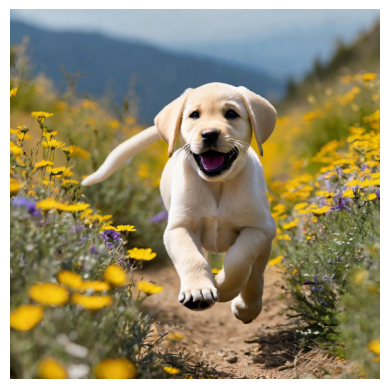

In [20]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

def display_image(image_url):
    """Display generated image"""
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

image_url = event['messages'][-2].content
display_image(image_url)

In [21]:
import uuid

_printed = set()
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "image_url": image_url,
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

events = graph.stream(
    {"messages": ("user", questions[3])}, config, stream_mode="values"
)
for event in events:
    _print_event(event, _printed)

================================ Human Message =================================

Tell me a story about this image
================================== Ai Message ==================================
Tool Calls:
  image2text (call_hyds)
 Call ID: call_hyds
  Args:
    image_url: https://replicate.delivery/pbxt/ZUOGdMQNXfVSVqqx4fMgvUVsxfqWNc2zbuETWt6OMf7kP5yLB/out-0.png
    prompt: Describe the scene in the image
================================= Tool Message =================================
Name: image2text

The image features a small, happy dog running through a field of flowers, with its tongue out and tail wagging. The dog appears to be enjoying its time in the field, surrounded by the vibrant colors of the flowers.
================================== Ai Message ==================================

What a lovely scene! It sounds like the dog is having the time of its life, running freely through the field of flowers. The image must be so vibrant and colorful, with the dog's happy energy 

In [22]:
_printed = set()
image_url = None
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "image_url": image_url,
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

events = graph.stream(
    {"messages": ("user", questions[4])}, config, stream_mode="values"
)
for event in events:
    _print_event(event, _printed)

================================ Human Message =================================

Convert this text to speech: The image features a small white dog running down a dirt path, surrounded by a beautiful landscape. The dog is happily smiling as it runs, and the path is lined with colorful flowers, creating a vibrant and lively atmosphere. The scene appears to be set in a mountainous area, adding to the picturesque nature of the image.
================================== Ai Message ==================================
Tool Calls:
  text2speech (call_xx1f)
 Call ID: call_xx1f
  Args:
    text: The image features a small white dog running down a dirt path, surrounded by a beautiful landscape. The dog is happily smiling as it runs, and the path is lined with colorful flowers, creating a vibrant and lively atmosphere. The scene appears to be set in a mountainous area, adding to the picturesque nature of the image.
================================= Tool Message =================================
Nam

In [23]:
from IPython.display import Audio

def play_audio(output_url):
    return Audio(url=output_url, autoplay=False)

audio_url = event['messages'][-2].content
play_audio(audio_url)